# Step-by-step Guide: Constructing a model with Phydrus

*Authors: R.A. Collenteur & M. Vremec*

This notebook is part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, G. Brunetti, M. Vremec & J. Simunek (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

---

This Notebook presents the basics steps to create a Phydrus model simulating water flow through the vadose zone. In the presented example, the workflow is divided into several steps, to demonstrate the usage of Phydrus methods:
1. Import the Phydrus package
2. Create the basic model
3. Add processes and materials
4. Add soil profile
5. Add Root Water Uptake
6. Add atmospheric boundary condition
7. Add observations nodes
8. Simulate the model
9. Post-process the results
___

### 1. Import the Pydrus package

In [1]:
import os
 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import phydrus as ps

### 2. Create the basic model & add time information
In the code block below a `Model` instance is created. The path to the Hydrus-1D executable has to be set at this stage. Phydrus will check the executable, and raise an Error if it is not found. 

In [15]:
#Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../../hydrus")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              time_unit="days", length_unit="cm")

ml.add_time_info(tinit=0, tmax=730);

### 3. Add processes and materials
In this step a model for the water flow is selected and top and bottom boundary conditions, using the `ml.add_waterflow` method. After that, we can use the `get_empty_material_df` method to obtain an empty DataFrame to define our soil hydraulic parameters for the different soil materials. In this example, the model contains to soil materials.

In [16]:
ml.add_waterflow(model=0, top_bc=3, bot_bc=4)

m = ml.get_empty_material_df(n=2)
m.loc[0:2] = [[0.0, 0.3382, 0.0111, 1.4737, 13, 0.5],
              [0.0, 0.3579, 0.0145, 1.5234, 50, 0.5]]
ml.add_material(m)

water                                 
    thr     ths    Alfa       n  Ks    l
1   0.0  0.3382  0.0111  1.4737  13  0.5
2   0.0  0.3579  0.0145  1.5234  50  0.5

### 4. Add Profile information
We develop the linear function of potential root water uptake distribution  $S^*_{p}(z)$ vs depth, following Hoffman and van Genuchten. 


\begin{equation}
S^*_{p} = \left \{
\begin{aligned}
&1 && \text{for} && z>L-r_1 \\
&\frac{z-[L-(r_1 + r_2)]}{r_2} && \text{for} && L-r_1 \geq z \geq L-(r_1 + r_2) \\
&0 && \text{for} && L-r_1 z < L-(r_1 + r_2) 
\end{aligned} \right.
\end{equation} 

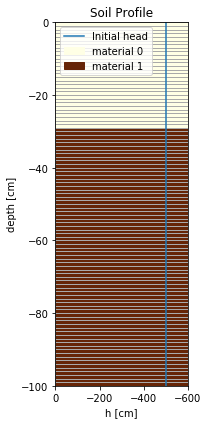

In [17]:
# Define loop for potential root water uptake distribution proposed by Hoffman and Van Genuchten
def z_loop(z, r1 = 10, r2 = 20):
    if z > -r1:
        return 1
    elif z < -(r1 + r2):
        return 0
    else:
        return(z+(r1+r2))/r2

bottom = [-30, -100]  # Depth of the soil column
nodes = 150  # Dictretize into n nodes
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=[1,2])
profile["Beta"] = profile.apply(lambda row: z_loop(row["x"]), axis=1)
ml.add_profile(profile)
ml.plots.profile(figsize=(3,6))

### 5. Add atmosphere boundary conditions
Atmospheric boundary condition can be added easily by reading in a CSV file using Pandas `read_csv` method and adding it to the model. 

In [18]:
atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

### 6. Add root water uptake

In [19]:
ml.add_root_uptake(model=0, p2h=-1500, p2l=-1500, poptm=[-25, -25])

### 7. Add observation nodes

In [20]:
#Number of the node -- > write script to get node closest to desired depth
ml.add_obs_nodes([-30, -60])

### 8. Write hydrus input files & run hydrus 
Before we can simulate, we write all model information to files. 

In [21]:
ml.write_input(verbose=False)
ml.simulate()

Successfully wrote output/SELECTOR.IN
Successfully wrote output/PROFILE.DAT
Successfully wrote output/ATMOSPH.IN


CompletedProcess(args=['/Users/Raoul/Projects/phydrus/examples/phydrus_paper/Ex1/../../hydrus', 'output', '-1'], returncode=0)

### 9a. Plot results
Plot pressure for soil column at the end of the simulation.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b94d410>,
      dtype=object)

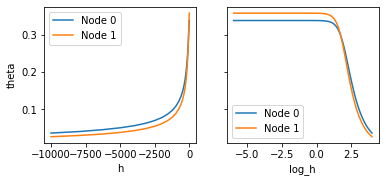

In [26]:
ml.plots.soil_properties(figsize=(6, 2.5))
#plt.savefig("../../figures/soil_properties.eps", bbox_inches="tight", dpi=300)

### 9b. Plot the drainage over time

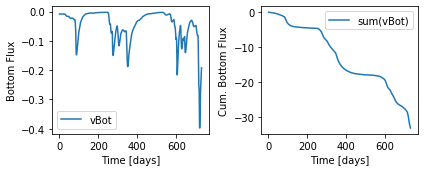

In [27]:
axes = ml.plots.water_flow("Bottom Flux", figsize=(6, 2.5))
#plt.savefig("../../figures/water_flow.eps", bbox_inches="tight", dpi=300)

### 9c. Plot the water content over time

[Text(-100.0, 0, 'Jan-07'), Text(0.0, 0, 'Jan-08'), Text(100.0, 0, 'Jan-09')]

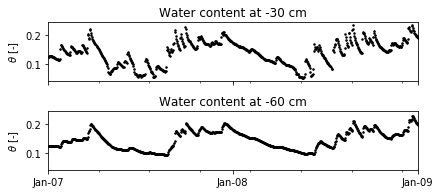

In [28]:
df = ml.read_obs_node()

fig, [ax0, ax1] = plt.subplots(2,1, figsize=(6,3), sharex=True, sharey=True)
df[ml.obs_nodes[0]]["theta"].plot(ax=ax0, marker=".", c="k", linestyle="", markersize=3)
ax0.set_title("Water content at -30 cm")
ax0.set_ylabel(r"$\theta$ [-]")

df[ml.obs_nodes[1]]["theta"].plot(ax=ax1, marker=".", c="k", linestyle="", markersize=3)
ax1.set_title("Water content at -60 cm")
ax1.set_ylabel(r"$\theta$ [-]")
plt.tight_layout()
ax1.set_xlabel("")
ax1.set_xlim(0,730)
ax1.set_xticks([0,365,730])
ax1.set_xticklabels(["Jan-07", "Jan-08", "Jan-09"])
#plt.savefig("../../figures/water_content.eps", bbox_inches="tight", dpi=300)

In [12]:
df[ml.obs_nodes[0]].to_csv("../data/wc_30cm.csv")
df[ml.obs_nodes[1]].to_csv("../data/wc_60cm.csv")

### 9c. Update the soil profile plot with the pressure head

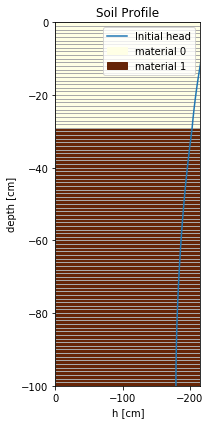

In [25]:
head = ml.read_nod_inf(times=[730]).iloc[:, 2]
ml.profile.loc[:, "h"] = head
ml.plots.profile()